## Challenge: Decision Tree vs. Random Forest

For this challenge, I will use the same dataset that I explored in Unit 2, which is compiled from the [Student Alcohol Consumption survey](https://www.kaggle.com/uciml/student-alcohol-consumption), which includes social, gender, and study data from secondary school students at two schools in Brazil. The data were made available on Kaggle in two csv files: one for math students and one for Portuguese language students. Let's load the data and get reacquainted with it.

The goal of the challenge is to construct a decision tree classifer and an ensemble random forest classifier, and compare their accuracy and runtimes.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from IPython.display import Image

import pydotplus
import graphviz

import time

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.mlab import PCA as mlabPCA

import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
sns.set_style("whitegrid")

por = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/student-por.csv')
mat = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/student-mat.csv')

In [2]:
print(len(por))
por.head()

649


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [3]:
print(len(mat))
mat.head()

395


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### Feature selection

There are 33 variables; most are categorical, while there are some ordinal items related to parental level of education, commute time, study time, and past academic performance. Other scalar items related to social activities and frequency of alcohol consumption are measured on a 5-point scale and could be modeled as continuous variables. 

The two datasets include the same variables, so let's add them together, including an additional variable to track which subject they come from. Then, we will take a look at the distributions of the scalar items and relationships among them in a scatterplot matrix. 

Because of the large number of variables in this dataset, after this initial perusal, we will select a subset of variables to work with. Since we're working with classifiers in this dataset, let's select a binary variable for our outcome: whether or not a student participates in extracurriculuar activities.

In [4]:
mat['subject'] = 'math'
por['subject'] = 'portuguese'
df = mat.append(por, ignore_index=True)

To get started, let's get a descriptive overview of the data, including a sense for how many missing items there are, with descriptions.

In [5]:
#Generate descriptions for each column.

start_time = time.time()

for col in df.columns:
    print(df[col].describe())
    
print("--- %s seconds ---" % (time.time() - start_time))

count     1044
unique       2
top         GP
freq       772
Name: school, dtype: object
count     1044
unique       2
top          F
freq       591
Name: sex, dtype: object
count    1044.000000
mean       16.726054
std         1.239975
min        15.000000
25%        16.000000
50%        17.000000
75%        18.000000
max        22.000000
Name: age, dtype: float64
count     1044
unique       2
top          U
freq       759
Name: address, dtype: object
count     1044
unique       2
top        GT3
freq       738
Name: famsize, dtype: object
count     1044
unique       2
top          T
freq       923
Name: Pstatus, dtype: object
count    1044.000000
mean        2.603448
std         1.124907
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: Medu, dtype: float64
count    1044.000000
mean        2.387931
std         1.099938
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Nam

It appears that there are no missingness indicators in the dataset, so we're ready to start investigating the distribution of the different variables. First, let's make sure that our outcome variable is relatively balanced. 

In [6]:
#Make sure the classes are balanced.
df['activities'].value_counts()

no     528
yes    516
Name: activities, dtype: int64

Next, we'll start visualizing the distributions. The kde plots on the diagonal in the grid below show that the 'free time' and 'go out' variables are somewhat normally distributed, while the others are not. The 'quality of family relationships' and 'health' variables are left-skewed, while 'weekday alcohol consumption' and 'weekend alcohol consumption' are right-skewed, corresponding to something like a lognormal distribution.

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


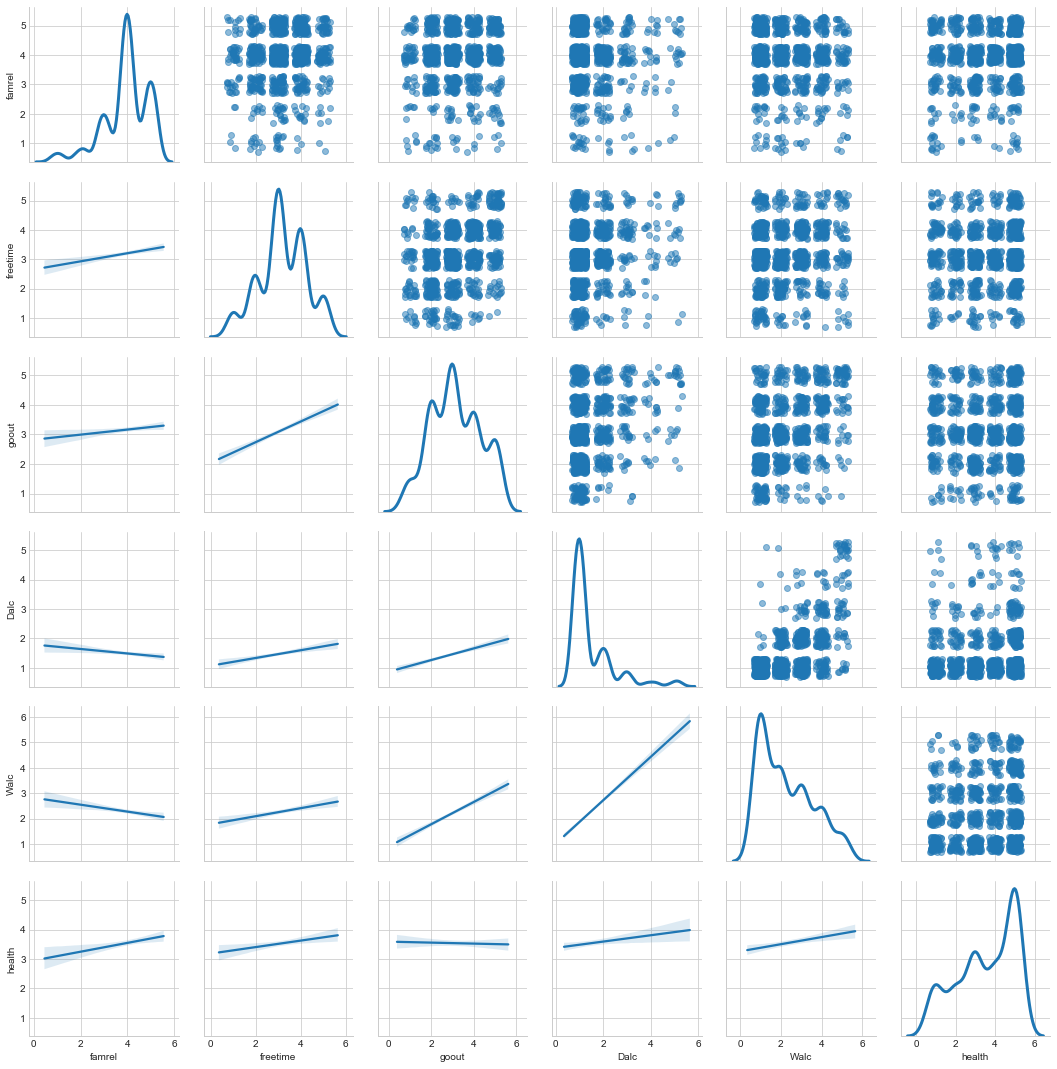

In [7]:
# Make the scatterplot matrix of the 1-5 scale items.
# We'll create a dataframe of random noise (or "jitter") and add it to the plot.

# Make a copy of the data to add jitter to and plot.
df_jittered = df.loc[:, 'famrel':'health']

# Make the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)

# Combine the data and the noise.

df_jittered = df_jittered.add(jitter)
#Declare the plot and plot.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Finally, we'll inspect all the numerical variables together in a correlation matrix.

                 age      Medu      Fedu  traveltime  studytime  failures  \
age         1.000000 -0.130196 -0.138521    0.049216  -0.007870  0.282364   
Medu       -0.130196  1.000000  0.642063   -0.238181   0.090616 -0.187769   
Fedu       -0.138521  0.642063  1.000000   -0.196328   0.033458 -0.191390   
traveltime  0.049216 -0.238181 -0.196328    1.000000  -0.081328  0.087177   
studytime  -0.007870  0.090616  0.033458   -0.081328   1.000000 -0.152024   
failures    0.282364 -0.187769 -0.191390    0.087177  -0.152024  1.000000   
famrel      0.007162  0.015004  0.013066   -0.012578   0.012324 -0.053676   
freetime    0.002645  0.001054  0.002142   -0.007403  -0.094429  0.102679   
goout       0.118510  0.025614  0.030075    0.049740  -0.072941  0.074683   
Dalc        0.133453  0.001515 -0.000165    0.109423  -0.159665  0.116336   
Walc        0.098291 -0.029331  0.019524    0.084292  -0.229073  0.107432   
health     -0.029129 -0.013254  0.034288   -0.029002  -0.063044  0.048311   

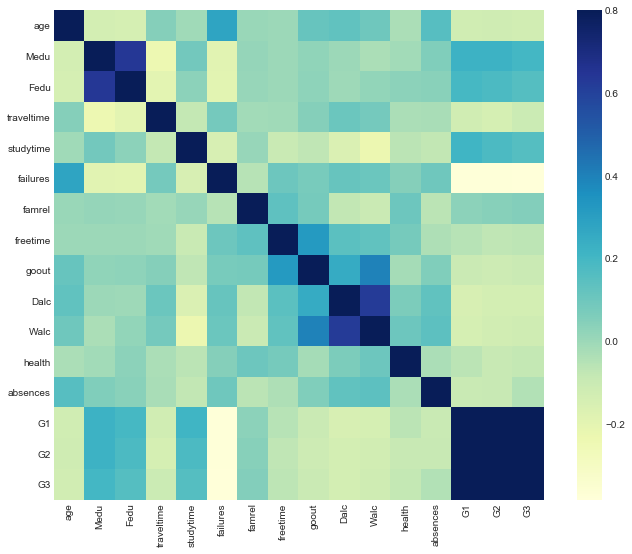

In [8]:
# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")
plt.show()

The grades and parental education variables are highly correlated with each other. Let's run some PCA to simplify this feature space before constructing the decision trees.

Covariance Matrix:
 [[ 1.00095877  0.85956209  0.8099175 ]
 [ 0.85956209  1.00095877  0.91161636]
 [ 0.8099175   0.91161636  1.00095877]]
The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.90658352  0.0662565   0.02715998]


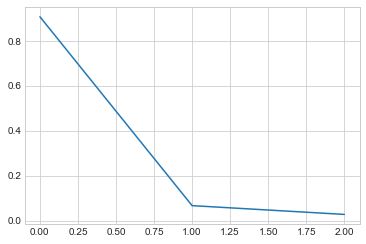

In [9]:
#Select the grades variables.
df_grades = df.loc[:, 'G1':'G3']

#Normalize the variables.
X = StandardScaler().fit_transform(df_grades)

# Transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

#Run PCA analysis on the two variables
sklearn_pca = PCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

plt.plot(sklearn_pca.explained_variance_ratio_)
plt.show()

#Assign the first component to the dataframe.
df['grades'] = Y_sklearn[:, 0]
df.drop(['G1','G2','G3'], 1, inplace=True)

In [10]:
#Select the parental education variables.
df_par = df[['Fedu','Medu']]

#Normalize the variables.
X = StandardScaler().fit_transform(df_par)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

sklearn_pca = PCA(n_components=2)
sklearn_pca = sklearn_pca.fit(X)
Y_sklearn = sklearn_pca.transform(X)


print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

#Add the first component back to our featureset.
df['Paredu'] = Y_sklearn[:, 0]

Covariance Matrix:
 [[ 1.00095877  0.64267874]
 [ 0.64267874  1.00095877]]
The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.82103157  0.17896843]


Currently, travel time is on a 1-4 scale where 4 is the maximum. Since long travel time is probably negatively correlated with time for other activities (e.g., study, extracurriculars), let's reverse the scale so that lower numbers indicate long commutes, and high numbers indicate short commutes.

In [11]:
df['commute'] = max(df['traveltime']) - df['traveltime']

Let's turn now to the categorical variables, and their relationships to the continuous variables. First, let's look at the bivariate relationships between the continuous variables and the outcome variable: participation in extracurricular activities. The boxplots below do not show salient differences between the two groups, but they do show some outliers in the absences group that we might want to keep an eye on.

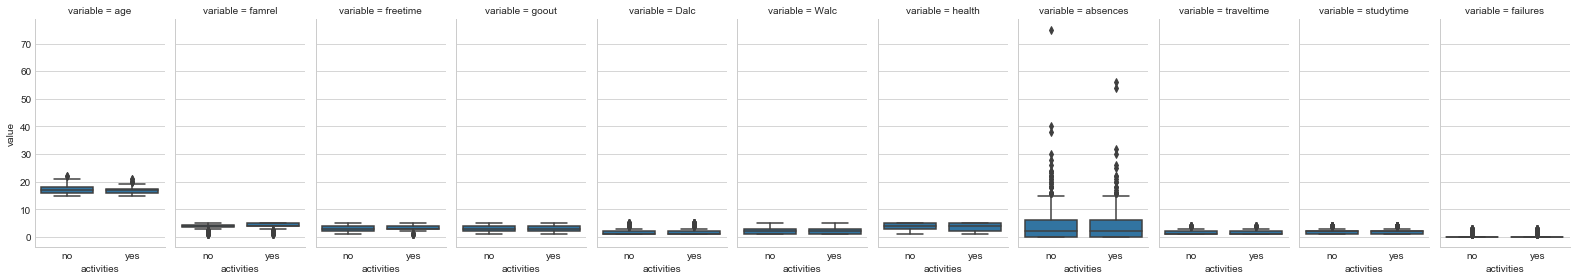

In [12]:
#Check for outliers and differences w.r.t. extracurricular activities.

df_long1 = pd.concat([df['activities'], df['age'], df.loc[:, 'famrel':'absences'], df['traveltime'], df['studytime'], df['failures']], axis=1)
df_long1melt = pd.melt(df_long1, id_vars=['activities'])

g = sns.FacetGrid(df_long1melt, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "activities", "value")
plt.show()

Based on the plots, we can see that 'absences' has many outliers. We will adjust for this by splitting 'absences' into a categorical variable. 

In [13]:
df['absentee'] = np.where(df['absences']>=5, 2, (np.where(df['absences']<=1, 1, 0)))

#Check the relationship of 'absentee' to the outcome variable.
pd.crosstab(df['activities'], df['absentee'], margins=True)

absentee,0,1,2,All
activities,,,,
no,152,206,170,528
yes,184,168,164,516
All,336,374,334,1044


Most students have no prior failures, but a few do. Let's split this variable into a binary feature.

In [14]:
print(df['failures'].value_counts())

df['failures'] = np.where(df['failures']>0, 1, 0)

pd.crosstab(df['activities'], df['failures'], margins=True)

0    861
1    120
2     33
3     30
Name: failures, dtype: int64


failures,0,1,All
activities,,,
no,427,101,528
yes,434,82,516
All,861,183,1044


Returning to the observation that the alcohol consumption variables are not normally distributed, it may be best to re-engineer these variables as binary categories: drinkers and non-drinkers. Let's take a look at the survey responses to decide where to split them. 

Later, during tuning and cross-validation, we'll test how well these different features fare in the model.

In [15]:
print(df['Dalc'].value_counts())
print(df['Walc'].value_counts())

df['day_drinker'] = np.where(df['Dalc']>=3, 1, 0)
df['weekend_drinker'] = np.where(df['Walc']>=3, 1, 0)

1    727
2    196
3     69
5     26
4     26
Name: Dalc, dtype: int64
1    398
2    235
3    200
4    138
5     73
Name: Walc, dtype: int64


Before running our models, let's use crosstabulations to check for interactions between some of the social categories and the outcome variable.

In [16]:
pd.crosstab(df['day_drinker'], df['activities'], margins=True)

activities,no,yes,All
day_drinker,,,
0,464,459,923
1,64,57,121
All,528,516,1044


In [17]:
pd.crosstab(df['weekend_drinker'], df['activities'], margins=True)

activities,no,yes,All
weekend_drinker,,,
0,323,310,633
1,205,206,411
All,528,516,1044


In [18]:
pd.crosstab(df['internet'], df['activities'], margins=True)

activities,no,yes,All
internet,,,
no,125,92,217
yes,403,424,827
All,528,516,1044


In [19]:
pd.crosstab(df['romantic'], df['activities'], margins=True)

activities,no,yes,All
romantic,,,
no,351,322,673
yes,177,194,371
All,528,516,1044


In [20]:
pd.crosstab(df['sex'], df['activities'], margins=True)

activities,no,yes,All
sex,,,
F,329,262,591
M,199,254,453
All,528,516,1044


In [21]:
pd.crosstab([df['sex'], df['romantic']], df['activities'], margins=True)

activities     no  yes   All
sex romantic                
F   no        198  156   354
    yes       131  106   237
M   no        153  166   319
    yes        46   88   134
All           528  516  1044

### Decision Tree

Now that we have a clean feature set, we're ready to try a decision tree classifier to predict whether or not high school students in the dataset participate in extracurricular activities. 

In [22]:
#Set up the predictors and the target variable. 
#Get dummies for the categorical variables.
X = df.drop('activities', 1)
X = pd.get_dummies(X)
Y = df['activities']

In [23]:
#Track runtime.
start_time = time.time()

#Initialize model. The dataset is small, so max_features is set to None.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=None,
    max_depth=None,
)
decision_tree.fit(X, Y)

#Cross-validate using 10 folds.
score = cross_val_score(decision_tree, X, Y, cv=10)

print("--- %s seconds ---" % (time.time() - start_time))
print(score)
print(score.mean())
print(score.var())

--- 0.11762571334838867 seconds ---
[ 0.85714286  0.92380952  0.80952381  0.73333333  0.80952381  0.80952381
  0.68269231  0.61538462  0.48543689  0.65048544]
0.737685639603
0.0153628350129


After tuning the parameters and running the model a few times, we've arrived at the best result. Since 'max_depth' is set to None, the tree cannot be visualized. Although the model's mean accuracy is 74.8%, cross-validation with 10 folds indicates that it suffers from overfitting, as accuracy scores range from 51.4%-88.6%. 

With just 1044 rows, and a depth of 5, the tree runs in 0.125 seconds. 

Other values for max_depth were tested in previous iterations, but the variance in cross-validation only improved with an overall accuracy tradeoff that yielded a mean accuracy close to chance. 

Now, let's try an ensemble Random Forest model, which improves the performance of the Decision Tree classifier. 

In [24]:
start_time = time.time()

rfc = ensemble.RandomForestClassifier(
    criterion='gini',
    max_features='log2',
    max_depth=None,
    n_estimators=150)

rfc.fit(X, Y)

score = cross_val_score(rfc, X, Y, cv=10)

print("--- %s seconds ---" % (time.time() - start_time))
print(score)
print(score.mean())
print(score.var())

--- 3.36637806892395 seconds ---
[ 0.99047619  0.98095238  0.92380952  0.8952381   0.96190476  0.8952381
  0.80769231  0.75        0.5631068   0.70873786]
0.847715601551
0.0172946035777


After tuning some parameters, we arrive at a result with a mean accuracy of 84.2%, and scores varying from 58.3%-97.1% in cross-validation. The variation in accuracy indicates either that the ensemble RFC suffers from some of the same overfitting as the lone Decision Tree above, or that the data simply aren't adequare for making this prediction. We can observe, in particular, that the ninth fold stands out as having particularly low accuracy, a result which recurred with each attempt to tune the classifer.

The model, using 150 estimators and no maximum depth, takes 2.86 seconds to run. With a dataset 1000x the size of this one, the model might become unwieldy and time-consuming to run. We would probably need to set a max-depth and other parameters to stop the growth of the tree. 

As for the accuracy of the classifier, the exploration of features above revealed no obvious predictors of participation in extracurricular activities. The poor cross-validation results here might be manifesting the "garbage in, garbage out" principle. None of the continuous features visualized in the boxplots showed an obvious difference, and none of the crosstabulations with other categorical features indicated strong difference between cells. We should therefore anticipate that this dataset might not be able to give a very strong prediction.